# Maszynka do Liczenia Monet

![coin_counter_image.png](https://live.staticflickr.com/65535/54326911769_4e446cdd97_k.jpg)
*Obraz wygenerowany przy użyciu modelu Flux-dev.*

## Wstęp
Wyobraź sobie, że na strychu odkrywasz duży kufer pełen monet i postanawiasz policzyć ich łączną wartość. Ręczne przeliczanie każdej z monet byłoby czasochłonne i nudne, dlatego decydujesz się na zautomatyzowanie rozwiązania. Na podstawie zdjęć rozrzuconych monet, twoim celem jest określenie ich wspólnej wartości.
Rozbijając to zadanie na czynniki pierwsze, Twoim zadaniem będzie:
* zlokalizowanie każdej monety na zdjęciu,
* przypisanie ich do odpowiednich kategorii według nominałów (np. 1 grosz czy 2 złote).

Zadanie to w dziedzinie wizji komputerowej nazywamy detekcją obiektów. Zwróć uwagę, że zadanie detekcji oznacza jednoczesne zadanie klasyfikacji, jak i regresji - musisz bowiem określić zarówno klasę obiektu, jak i jego położenie na zdjęciu. Dodatkowym wyzwaniem, który odróżnia detekcję od zwykłego zadania klasyfikacji jest fakt, że zamiast jednego obiektu reprezentującego jedną z klas, na zdjęciu może znajdować się wiele obiektów różnych klas.

Formalnie możemy powiedzieć, że rozwiązaniem $\hat{\mathcal{B}}$ powinien być zbiór krotek, zawierających, kolejno, współrzędne prostokąta, w którym znajduje się moneta, etykietę, która określa nominał monety, a także pewność, z jaką model jest przekonany, że znalazł monetę.
$$
\hat{\mathcal{B}} = \{(x_{min}, y_{min}, x_{max}, y_{max}, c, \phi), \dots\}
$$
gdzie $(x_{min}, y_{min})$ to lewy górny róg prostokąta, $(x_{max}, y_{max})$ to prawy dolny róg prostokąta, $c$ to etykieta monety, a $\phi$ to pewność modelu co do predykcji. W zależności od zdjęcia, zbiór $\hat{\mathcal{B}}$ może posiadać różną ilość elementów, odpowiadającą ilości znalezionych monet. Kolejność monet w zbiorze nie ma znaczenia.

*Uwaga*: Przy pozycjach prostokątów na zdjęciu, warto zwrócić uwagę, że punkt (0, 0) znajduje się w lewym górnym rogu obrazu, a oś Y rośnie w dół. Jest to standardowy układ współrzędnych stosowany w grafice komputerowej, który różni się od układu współrzędnych stosowanego w matematyce.

Podczas wykonywania detekcji możemy popełnić pięć rodzajów błędów, które zostały przedstawione na poniższych obrazkach:
- Model wykrył obiekt, w miejscu gdzie go nie ma (taką sytuację nazywamy False Positive)
- Model nie wykrył obiektu, który jest na obrazie (taką sytuację nazywamy False Negative)
- Model wykrył obiekt, ale niepoprawnie go zaklasyfikował
- Model poprawnie wykrył i zaklasyfikował obiekt, ale zwrócił nieprecyzyjne współrzędne prostokąta
- Model wykrył ten sam obiekt kilka razy

![coin_counter_prediction.png](https://live.staticflickr.com/65535/54327101055_460ce3640e_k.jpg)

W tym przypadku bierzemy pod uwagę tylko polskie monety i ograniczamy się do stron nominalnych. Zarówno banknoty, jak i strona z wizerunkiem orła nie są zawarte w zbiorze danych i nie są brane pod uwagę. 

[Link](https://github.com/OlimpiadaAI/szkolenia/blob/main/12_Zadania_detekcji_i_segmentacji.pdf) do slajdów z wykładu na temat detekcji i segmentacji obiektów.

## Zadanie
Twoim zadaniem jest zaimplementowanie klasy ```YourDetector```, w której metoda ```forward``` przyjmuje obraz i zwraca zbiór zawierający predykcje monet w formacie opisanym przy definicji zbioru $\hat{\mathcal{B}}$.

### Kryterium Oceny
*Uwaga*: Zarówno metody obliczające metryki, jak i ładowanie danych zostały zaimplementowane w zadaniu. Twoim jedynym celem jest zaimplementowanie modelu detekcji, jednak zachęcamy do zapoznania się z opisem metryk, aby lepiej zrozumieć problem.

Zadanie zostanie ocenione na podstawie metryki [mAP](https://kili-technology.com/data-labeling/machine-learning/mean-average-precision-map-a-complete-guide) (ang. *mean Average Precision*), która jest standardową metryką w dziedzinie detekcji obiektów.  
Wyznaczenie tej metryki zaczyna się od sparowania predykcji z prawdziwymi obiektami. W tym celu wykorzystuje się metrykę IoU (ang. *Intersection over Union*), która określa stopień pokrycia dwóch prostokątów. Wartość IoU jest zdefiniowana jako stosunek pola wspólnego dla obu prostokątów $A_{\text{inter}}$ do pola ich sumy $A_{\text{union}}$.
$$ IoU = \frac{A_{\text{inter}}}{A_{\text{union}}} $$
Patrząc na poniższy rysunek, możemy powiedzieć, że IoU to stosunek pola żółtego do pola niebieskiego. Warto zauważyć, że jeśli prostokąty nie miałyby części wspólnej, to wartość IoU wynosiłaby $0$, a jeśli oba prostokąty byłyby identyczne, to wartość IoU wynosiłaby $1$.
Wartość IoU musi przekroczyć ustalony próg, abyśmy mogli uznać, że dwa prostokąty się pokrywają. Im wyższy próg, tym bardziej dokładne muszą być wskazane lokalizacje obiektów przez model, żeby zostały one sparowane z prostokątami utworzonymi na podstawie rzeczywistych współrzędnych.

![coin_counter_explanation_1.png](https://live.staticflickr.com/65535/54326929064_3927b29b3b_k.jpg)

Po dopasowaniu predykcji modelu do rzeczywistych obiektów możemy obliczyć dwie kluczowe miary: precyzję (ang. *precision*) oraz czułość (ang. *recall*). Obie miary liczymy dla każdej klasy z osobna.
- Precyzja wyraża odsetek obiektów poprawnie sklasyfikowanych do danej klasy wśród wszystkich obiektów, które zostały do niej przypisane.
- Czułość opisuje odsetek prawidłowo sklasyfikowanych obiektów danej klasy w stosunku do wszystkich obiektów tej konkretnej klasy.

Te dwie miary pomagają ocenić skuteczność modelu. Jednak ponieważ modele są niedoskonałe i popełniają różnego rodzaju błędy, próba poprawy jednej z metryk wiąże się z reguły z pogorszeniem drugiej. Gdy dla przykładu zmniejszymy próg pewności modelu, będziemy brać pod uwagę większą liczbę obiektów wskazanych przez model, ale jednocześnie może to zwiększyć ilość obiektów fałszywie wskazanych przez model za istotne.

Aby lepiej zrozumieć ten kompromis, korzystamy z wartości pewności modelu (oznaczanej jako $\phi$) i wyznaczamy na ich podstawie krzywą precision-recall. Ta krzywa pokazuje, jak zmieniają się precyzja i czułość w zależności od ustawionego progu pewności.

Pole pod poniżej narysowaną krzywą to średnia precyzja (AP) dla danej klasy.

![coin_counter_explanation_2.png](https://live.staticflickr.com/65535/54326928103_12e06df704_z.jpg)

Metryka mAP, to średnia precyzja dla wszystkich klas, czyli średnie pole pod krzywą precision-recall dla wszystkich klas, opisane wzorem:
$$ mAP = \frac{1}{K} \sum_{k=1}^K {AP}_{k}, $$
gdzie $K$ to liczba klas, a ${AP}_{k}$ to średnia precyzja dla klasy $k$.

Ostatnim krokiem jest wybór wartości IoU, dla której chcemy wyznaczyć mAP. Standardową praktyką, którą wykorzystamy do ocenienia twojego rozwiązania, jest wyznaczanie mAP dla różnych wartości IoU (zaczynając od 0.5 i zwiększając wartość o 0.05 aż do 0.95) i uśrednianie wyników. Dzięki temu metryka lepiej odzwierciedla nie tylko jakość klasyfikacji ale także jakość lokalizacji obiektów (dla progu IoU=0.95 model musi zwracać predykcje niemal idealnie pokrywające się z docelowymi prostokątami, a w przypadku IoU=0.5 metryka "wybacza" znacznie większe różnice w położeniu).

**Ostatecznie Twoje rozwiązanie oceniane będzie na tajnym zbiorze testowym na podstawie metryki mAP.** Zbiór testowy nie różni się znacząco od zbioru walidacyjnego.

- Gdy wartość mAP dla Twojego modelu będzie wynosiła 0.2 (lub poniżej), otrzymasz 0 punktów za zadanie.
- Gdy wartość mAP dla Twojego modelu będzie wynosiła 0.85 (lub powyżej), otrzymasz 100 punktów za zadanie.
- W przeciwnym wypadku, liczba punktów zostanie wyznaczona proporcjonalnie do wartości mAP:
$$
\text{score} = \frac{mAP - 0.2}{0.85 - 0.2} \times 100
$$


## Ograniczenia
- Twoje rozwiazanie będzie testowane na Platformie Konkursowej bez dostępu do internetu oraz w środowisku z GPU.
- Ewaluacja Twojego finalnego rozwiązania na Platformie Konkursowej nie może trwać dłużej niż 10 minut z GPU, natomiast ewaluacja dla pojedyńczego zdjęcia nie może trwać dłużej niż 5 sekund.
- Model nie może korzystać z innych zbiorów danych oraz z pre-trenowanych wag na innych zbiorach danych.
- Model musi zwracać wyniki w formacie, który jest kompatybilny z funkcją ```predict_all_bounding_boxes``` (podobnie jak przykładowe rozwiązanie).
- Model musi dziedziczyć po klasie ```nn.Module```.

## Pliki Zgłoszeniowe
Ten notebook uzupełniony o Twoje rozwiązanie (patrz klasa `YourDetector`).

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`.

Za to zadanie możesz zdobyć pomiędzy 0 a 100 punktów. Liczba punktów, którą zdobędziesz, będzie wyliczona na (tajnym) zbiorze testowym na Platformie Konkursowej na podstawie wyżej wspomnianego wzoru, zaokrąglona do liczby całkowitej. Jeśli Twoje rozwiązanie nie będzie spełniało powyższych kryteriów lub nie będzie wykonywać się prawidłowo, otrzymasz za zadanie 0 punktów.

# Kod Startowy
W tej sekcji inicjalizujemy środowisko poprzez zaimportowanie potrzebnych bibliotek i funkcji. Przygotowany kod ułatwi Tobie efektywne operowanie na danych i budowanie właściwego rozwiązania.

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

FINAL_EVALUATION_MODE = False  # Podczas sprawdzania ustawimy tą flagę na True.

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

import os
import torch
import pickle
import gdown
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms.v2 as T
from collections.abc import Callable
from matplotlib import patches
from matplotlib.collections import PatchCollection
from torchvision.models import resnet18
from torchvision.ops import box_iou
from torch.utils.data import Dataset
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert torch.cuda.is_available(), "CUDA niedostępna!"

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

seed = 12345

os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do przygotowania danych.

class CoinsDataset(Dataset):
    """
    Zbiór danych monet wczytywany z pliku pickle.
    
    Przyjmuje:
        pickle_file (str): Ścieżka do pliku pickle zawierającego dane.
        transform (callable, opcjonalnie): Transformacje stosowane do obrazów i etykiet.
    """
    def __init__(
            self, 
            pickle_file: str, 
            transform: Callable | None = None
        ):
        self.transform = transform

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

    def __len__(self) -> int:
        """Zwraca liczbę próbek w zbiorze danych."""
        return len(self.data)
    
    def __getitem__(
            self, 
            idx: int
        ) -> dict:
        """
        Pobiera próbkę danych na podstawie indeksu.
        
        Przyjmuje:
            idx (int): Indeks próbki.
        
        Zwraca:
            dict: Słownik zawierający obraz oraz odpowiadające mu obiekty docelowe (boxes, labels).
        """
        sample = self.data[idx]
        image = sample['image']
        target = {
            'boxes': sample['boxes'],
            'labels': sample['labels']
        }

        if self.transform:
            image, target = self.transform(image, target)

        return {
            'image': image,
            **target
        }


def setup_data(
        train_transform: Callable | None = None, 
        val_transform: Callable | None = None, 
        root: str = 'data/'
    ) -> tuple:
    """
    Przygotowuje zbiory danych do trenowania i walidacji, pobierając je jeśli to konieczne.
    
    Przyjmuje:
        train_transform (callable, opcjonalnie): Augmentacje dla zbioru treningowego.
        val_transform (callable, opcjonalnie): Augmentacje dla zbioru walidacyjnego.
        root (str, opcjonalnie): Katalog bazowy dla plików z danymi.
    
    Zwraca:
        tuple: Zbiory danych (train_ds, val_ds).
    """
    if train_transform is None:
        train_transform = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])
    if val_transform is None:
        val_transform = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

    train_file = root+'train.pkl'
    val_file = root+'val.pkl'

    if not os.path.exists(root):
        os.makedirs(root)

    if not os.path.exists(train_file):
        url = "https://drive.google.com/uc?id=1KC8FBlCuwh9ITUt0CcPeRJCpqy5j4WBp"
        gdown.download(url, train_file, quiet=True)

    if not os.path.exists(val_file):
        url = "https://drive.google.com/uc?id=1Oza4UjnmAUeae2cA8YDwMWxVHOb7SKdP"
        gdown.download(url, val_file, quiet=True)

    train_ds = CoinsDataset(root+'train.pkl', transform=train_transform)
    val_ds = CoinsDataset(root+'val.pkl', transform=val_transform)

    return train_ds, val_ds


In [5]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do wyznaczenia metryk oceniających jakość modelu.

def predict_all_bounding_boxes(
        model: nn.Module, 
        ds: Dataset
    ) -> list:
    """
    Funkcja przewidująca wszystkie bounding boxy dla zbioru danych z wykorzystaniem modelu.

    Przyjmuje:
        model: Model detekcji obiektów.
        ds: Zbiór danych.

    Zwraca:
        Lista zawierająca wszystkie przewidziane bounding boxy dla każdej próbki w zbiorze danych.
    """
    all_pred_bboxes = []

    for sample in ds:
        img = sample["image"].to(DEVICE)
        pred_bboxes = model(img)
        all_pred_bboxes.append(pred_bboxes)

    return all_pred_bboxes


def calculate_map(
        predictions: list, 
        ds: Dataset, 
        return_all: bool = False
    ) -> dict | float:
    """
    Funkcja obliczająca średnią precyzję średnią (mAP) dla przewidzianych bounding boxów dla całego zbioru danych.

    Przyjmuje:
        predictions: Lista zawierająca przewidziane bounding boxy dla każdej próbki w zbiorze danych.
        ds: Zbiór danych, zawierający prawdziwe bounding boxy.
        return_all (bool, opcjonalnie): Czy zwrócić wszystkie metryki, czy tylko mAP:0.5:0.95:0.05.

    Zwraca:
        Wartość mAP lub wszystkie metryki w formie słownika.
    """
    meta = []

    for img_meta in predictions:
        entry = {
            "boxes": [],
            "labels": [],
            "scores": []
        }

        for box in img_meta:
            entry["boxes"].append(box[:4])
            entry["labels"].append(box[4])
            entry["scores"].append(box[5])

        meta.append(entry)

    for i in range(len(meta)):
        meta[i]['boxes'] = torch.tensor(meta[i]['boxes'])
        meta[i]['labels'] = torch.tensor(meta[i]['labels']).view(-1)
        meta[i]['scores'] = torch.tensor(meta[i]['scores'])

    mAP = MeanAveragePrecision()

    GT = [{
        "boxes": sample["boxes"],
        "labels": sample["labels"]
    } for sample in ds]

    output = mAP(meta, GT)

    if return_all:
        return output

    return mAP(meta, GT)['map'].item()

def compute_confusion_matrix(
        predictions: list, 
        ds: Dataset, 
        iou_threshold: float = 0.5
    ) -> np.ndarray:
    """
    Funkcja obliczająca macierz pomyłek dla przewidzianych bounding boxów dla całego zbioru danych.

    Przyjmuje:
        predictions: Lista zawierająca przewidziane bounding boxy dla każdej próbki w zbiorze danych.
        ds: Zbiór danych, zawierający prawdziwe bounding boxy.
        iou_threshold (float, opcjonalnie): Próg IoU dla przypisania predykcji do obiektu.

    Zwraca:
        Macierz pomyłek.
    """
    num_classes = 10  # 9 klas monet + 1 tło
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for pred_boxes, item in zip(predictions, ds):
        # Ground truth
        gt_boxes = item['boxes']
        gt_labels = item['labels']

        # predykcje
        pred_boxes_tensor = torch.tensor([p[:4] for p in pred_boxes]) if pred_boxes else torch.empty((0, 4))
        pred_labels = torch.tensor([p[4] for p in pred_boxes]) if pred_boxes else torch.empty((0,), dtype=torch.long)

        # wartości IoU dla wszystkich par predykcji i ground truth
        iou_matrix = box_iou(pred_boxes_tensor, gt_boxes) if pred_boxes else torch.empty((0, gt_boxes.shape[0]))

        # na podstawie IoU przypisz predykcje do ground truth
        matched_gt = set()
        for pred_idx, ious in enumerate(iou_matrix):
            max_iou, gt_idx = torch.max(ious, dim=0)
            if max_iou >= iou_threshold and gt_idx.item() not in matched_gt:  
                conf_matrix[gt_labels[gt_idx].item(), pred_labels[pred_idx].item()] += 1
                matched_gt.add(gt_idx.item())
            else:
                conf_matrix[-1, pred_labels[pred_idx].item()] += 1  # False positive

        # Dla wszystkich nieprzypisanych obiektów ground truth dodaj jako False negative
        for gt_idx in range(len(gt_boxes)):
            if gt_idx not in matched_gt:
                conf_matrix[gt_labels[gt_idx].item(), -1] += 1

    return conf_matrix

In [6]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do wizualiacji wyników

colors = ["red", "green", "blue", "yellow", "black", "purple", "orange", "brown", "pink"]
label_names = ['1 grosz', '2 grosze', '5 groszy', '10 groszy', '20 groszy', '50 groszy', '1 złotych', '2 złote', '5 złotych']

def show_sample(
        sample: dict
    ):
    """
    Funkcja wyświetlająca obraz z bounding boxami obiektów.

    Przyjmuje:
        sample: Słownik zawierający obraz oraz etykiety.
    """
    image = sample['image']
    meta = sample

    plt.figure(figsize=(9, 5))
    plt.imshow(image.permute((1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

    if meta is not None:
        patches_list = []
        legend_labels = []

        for bbox, label in zip(meta['boxes'], meta['labels']):
            points = np.array(bbox)
            points = points.astype(int)

            # Rysowanie prostokąta, który otacza obiekt
            rect = patches.Rectangle(
                (points[0], points[1]), 
                points[2] - points[0], 
                points[3] - points[1], 
                linewidth=2, 
                edgecolor=colors[label.item()],
                facecolor='none'
            )
            patches_list.append(rect)

            # legenda z unikalnymi etykietami
            if label_names[label.item()] not in legend_labels:
                legend_labels.append(label_names[label.item()])

        patch_collection = PatchCollection(patches_list, match_original=True)
        plt.gca().add_collection(patch_collection)

        # Dodanie legendy z unikalnymi etykietami
        handles = [patches.Patch(color=colors[i], label=label) for i, label in enumerate(label_names) if label in legend_labels]
        plt.legend(handles=handles, loc="upper right")

    plt.show()


def plot_detection_results_grid(
        predictions: list, 
        ds: Dataset, 
        size: tuple = (2, 3)
    ):
    """
    Funkcja wyświetlająca wyniki detekcji na wybranych zdjęciach walidacyjnych.

    Przyjmuje:
        predictions: Lista zawierająca przewidziane bounding boxy dla każdej próbki w zbiorze danych.
        ds: Zbiór danych.
        size (tuple, opcjonalnie): Rozmiar siatki obrazów.
    """

    fig, axes = plt.subplots(size[0], size[1], figsize=(size[1]*6, size[0]*5))

    for i, (sample, pred_meta) in enumerate(zip(ds, predictions)):
        if i >= size[0] * size[1]:
            break

        img = sample["image"]

        ax = axes[i // size[1], i % size[1]]
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')

        for x1, y1, x2, y2, label, _ in pred_meta:
            rect = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor=colors[label],
                facecolor='none',
            )
            ax.add_patch(rect)
    
    handles = [patches.Patch(color=colors[i], label=label) for i, label in enumerate(label_names)]
    plt.legend(handles=handles, loc='upper right')
    plt.suptitle("Detekcja monet na wybranych sześciu zdjęciach walidacyjych")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(
        predictions: list, 
        ds: Dataset, 
        iou_threshold: float = 0.5
    ):
    """
    Funkcja wyświetlająca macierz pomyłek dla detekcji monet.

    Przyjmuje:
        predictions: Wynik detekcji monet.
        ds: Zbiór danych.
        iou_threshold float: Próg IoU dla przypisania predykcji do obiektu 
    """
    conf_matrix = compute_confusion_matrix(predictions, ds, iou_threshold=iou_threshold)

    labels = ["1 grosz", "2 grosze", "5 groszy", "10 groszy", "20 groszy", "50 groszy", "1 złotych", "2 złote", "5 złotych", "brak (tło)"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)

    plt.xlabel("Model predykował", labelpad=15)
    plt.ylabel("podczas, gdy powinien był predykować", labelpad=15)
    plt.xticks(rotation=45)

    plt.title("Macierz pomyłek dla detekcji monet z użyciem IOU={}".format(iou_threshold))
    plt.show()

## Ładowanie Danych
Za pomocą poniższego kodu dane zostaną wczytane i odpowiednio przygotowane.

In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

train_ds, val_ds = setup_data(root='./data/')

if not FINAL_EVALUATION_MODE:
    print("Ilość zdjęć w zbiorze treningowym:", len(train_ds), ", ilość zdjęć w zbiorze walidacyjnym:", len(val_ds))

    sample = train_ds[0]

    print("Każda próbka zawiera:", list(sample.keys()))
    print("Każde zdjęcie ma wymiary:", list(sample["image"].shape))
    print("Ta próbka posiada", sample['labels'].shape[0], "obiektów")
    print("Każdy prostokąt jest opisany jako", sample['boxes'].shape[1], "wartości (x1, y1, x2, y2)")

    show_sample(sample) # wyświetlenie przykładowego zdjęcia z zaznaczonymi obiektami


### Klasy Obiektów i ich Etykiety
Poniżej znajduje się tabelka z etykietami klas znajduących się w zbiorze danych wraz z ich krótkim opisem.

| Etykieta | Opis |
| --- | --- |
| 0 | Moneta o nominale 1 grosza |
| 1 | Moneta o nominale 2 grosze |
| 2 | Moneta o nominale 5 groszy |
| 3 | Moneta o nominale 10 groszy |
| 4 | Moneta o nominale 20 groszy |
| 5 | Moneta o nominale 50 groszy |
| 6 | Moneta o nominale 1 złoty |
| 7 | Moneta o nominale 2 złote |
| 8 | Moneta o nominale 5 złotych |


## Przykładowe Rozwiązanie
Poniżej przedstawiamy uproszczone rozwiązanie, które służy jako przykład demonstrujący podstawową funkcjonalność notatnika. Może ono posłużyć jako punkt wyjścia do opracowania Twojego rozwiązania.

Jako prosty przykład może posłuży sieć konwolucyjna aplikowana na okno przesuwne. Metoda ta polega na wyciąganiu fragmentów zdjęcia (w naszym przypadku o rozmiarach typowych dla monet w zbiorze danych) i klasyfikacji każdego z nich przez sieć konwolucyjną. Sieć ta na wyjściu zwraca jedną z 10 klas: dziewięć z nich należy do różnych nominałów, natomiast ostatnia klasa jest zarezerwowania dla tła, czyli miejsca gdzie nie ma żadnej monety. Operację klasyfikacji przeprowadzamy dla każdego fragmentu zdjęcia, przesuwając się o określoną wartość. W przypadku, gdy sieć zwraca klasę tła, pomijamy ten fragment, w przeciwnym przypadku, do analizowanego fragmentu przypisujemy etykietę monety. W ten sposób otrzymujemy zbiór prostokątów, które zawierają monety.

Przy implementacji należy wziąć pod uwagę dodatkową klasę, która będzie reprezentować tło (prostokąt, w którym nie ma żadnej monety). W procesie treningu możemy robić losowe wycinki zdjęcia. Jeśli wycinek pokrywa się z monetą z wartością IoU wyższą niż $0.5$, to wybieramy jej nominał jako etykietę. W przypadku gdy wycinek nie pokrywa się z żadną monetą - wybieramy tło jako etykietę.

Zaczniemy od zdefiniowania prostego modelu, a w następnych komórkach zajmiemy się implementacją funkcji trenującej.

In [8]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

class BasicCNNClassifier(nn.Module):
    def __init__(self):
        super(BasicCNNClassifier, self).__init__()
        self.net = resnet18(weights=None, num_classes=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Funkcja klasyfikująca obraz x do jednej z 10 klas: 9 monet + tło.

        Przyjmuje:
            x (torch.Tensor): Obraz do klasyfikacji.

        Zwraca:
            torch.Tensor: Predykcje modelu.
        """
        return self.net(x)

In [9]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# kod do przerabiania zdjęcia z wieloma monetami do danych uczących dla klasyfikatora
# w 90% przypadków losujemy obiekt z obrazka i wycinamy jego otoczenie
# w 10% przypadków wybieramy zupełnie losowy fragment obrazka

class ClassificationDataPreprocessor:
    def __init__(
            self, 
            num_of_crops_per_image: int = 4, 
            box_size: int = 64
        ):
        self.num_of_crops_per_image = num_of_crops_per_image
        self.box_size = box_size

    def get_label_of_crop(
            self, 
            crop_box: tuple, 
            boxes: torch.Tensor, 
            labels: torch.Tensor,
            iou_threshold: float = 0.5
        ) -> int:
        """
        Funkcja zwracająca etykietę dla wycinka obrazu w zależności od tego, czy pokrywa się z monetą z wartością IoU > 0.5.

        Przyjmuje:
            crop_box (tuple): Coordynaty lewego-górnego oraz prawego-dolnego rogu wycinka obrazu (x1, y1, x2, y2).
            boxes (torch.Tensor): Tensor zawierający bounding boxy monet.
            labels (torch.Tensor): Tensor zawierający etykiety monet.
            iou_threshold (float): Próg IoU dla przypisania predykcji do obiektu.
        """
        for box, label in zip(boxes, labels):
            if box_iou(torch.tensor(crop_box).view(1, 4), box.view(1, 4)) > iou_threshold:
                return label
        return 9 # wartości 0-8 to etykiety monet, dlatego 9 będzie tłem

    def __call__(
            self, 
            batch: list
        ) -> dict:
        """
        Funkcja przetwarzająca obrazy z wieloma monetami na dane uczące dla klasyfikatora, zawierające wycinki obrazów z ich etykietami. 

        Przyjmuje:
            batch (list): Lista słowników zawierających obrazy, bounding boxy monet oraz ich etykiety.

        Zwraca:
            dict: Słownik zawierający wycinki obrazów oraz ich etykiety.
        """
        crops, labels = [], []

        for sample in batch:
            img = sample['image']

            for _ in range(self.num_of_crops_per_image):
                if torch.rand(1) < 0.1: # raz na 10 prób losujemy tło (staramy się w ten sposób zbalansować zbiór)
                    central_x = torch.randint(0, img.shape[2], (1,)).item()
                    central_y = torch.randint(0, img.shape[1], (1,)).item()
                else: # w pozostałych 90% losujemy obiekt z obrazka i wycinamy jego otoczenie
                    idx_gt = torch.randint(0, sample['labels'].shape[0], (1,)).item()
                    central_x = (sample['boxes'][idx_gt, 0] + sample['boxes'][idx_gt, 2]) // 2 + torch.randint(-10, 10, (1,)).item()
                    central_y = (sample['boxes'][idx_gt, 1] + sample['boxes'][idx_gt, 3]) // 2 + torch.randint(-10, 10, (1,)).item()

                x1 = np.clip(central_x - self.box_size // 2, 0, img.shape[2] - self.box_size)
                y1 = np.clip(central_y - self.box_size // 2, 0, img.shape[1] - self.box_size)
                x2, y2 = x1 + self.box_size, y1 + self.box_size

                crop = img[:, y1:y2, x1:x2]
                label = self.get_label_of_crop((x1, y1, x2, y2), sample['boxes'], sample['labels'])

                crops.append(crop)
                labels.append(label)

        return {
            "crops": torch.stack(crops, dim=0),
            "labels": torch.tensor(labels)
        }


In [10]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# kod do walidacji metodą okna przesuwnego

class SlidingWindowDetector(nn.Module):
    """
    Klasa implementująca detektor obiektów za pomocą metody okna przesuwnego. Jest to przykładowe rozwiązanie problemu detekcji monet.

    Przyjmuje:
        classifier (nn.Module): Model klasyfikatora obiektów. Dla każdej pozycji okna przesuwnego, 
                    klasyfikator zwraca predykcję dla danego wycinka obrazu.
        crop_size: Rozmiar okna przesuwnego
        stride: dystans o jaki przesuwamy okno w każdej iteracji.
    """
    def __init__(
            self, 
            classifier: nn.Module, 
            crop_size: int = 64, 
            stride: int = 32
        ):
        super(SlidingWindowDetector, self).__init__()
        self.classifier = classifier
        self.crop_size = crop_size
        self.stride = stride

    def forward(
            self, 
            image: torch.Tensor
        ) -> list:
        """
        Funkcja przewidująca obiekty na obrazie za pomocą metody okna przesuwnego.

        Przyjmuje:
            image: Obraz do przetworzenia.

        Zwraca:
            lista znalezionych obiektów w formie krotki (x1, y1, x2, y2, label, confidence).
        """
        # przenosimy obraz na odpowiednie urządzenie (takie jak model)
        device = next(self.parameters()).device
        image = image.to(device)

        found_objects = [] # lista obiektów, gdzie obiektem jest krotka (x1, y1, x2, y2, label, confidence)

        # przesuwamy okno po obrazie
        for y in range(0, image.shape[1] - self.crop_size, self.stride):
            for x in range(0, image.shape[2] - self.crop_size, self.stride):
                crop = image[:, y:y+self.crop_size, x:x+self.crop_size]
                pred = self.classifier(crop.unsqueeze(0))[0]

                if pred.argmax() != 9: # tło pomijamy
                    label = pred.argmax().item()
                    confidence = torch.softmax(pred, dim=0)[label].item()
                    found_objects.append((x, y, x+self.crop_size, y+self.crop_size, label, confidence))

        return found_objects


In [11]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

def train_basic_detector(
        train_ds: Dataset
    ) -> SlidingWindowDetector:
    """
    Funkcja trenująca klasyfikator monet za pomocą tworzenia wycinków obrazów i klasyfikowania ich. 
    Gdy klasyfikator jest wytrenowany, tworzymy detektor obiektów za pomocą metody okna przesuwnego (SlidingWindowDetector). 

    Przyjmuje:
        train_ds (Dataset): Zbiór danych treningowych.

    Zwraca:
        SlidingWindowDetector: Wytrenowany detektor obiektów korzystający z metody okna przesuwnego.
    """

    # jaki powinien być rozmiar okna przesuwnego? odpowiedź na to pytanie znajdziemy w danych...
    # wyznaczmy średni rozmiar wszystkich obiektów w zbiorze treningowym
    total = 0
    boxes = 0

    for sample in train_ds:
        total += sum(sample["boxes"][:, 2] - sample["boxes"][:, 0]) # x2 - x1 (zakładamy, że obiekty są kwadratowe, dlatego pomijamy y)
        boxes += len(sample["boxes"])

    box_size = (total / boxes).item()

    print("Średni rozmiar obiektu w zbiorze treningowym:", box_size) # powinno wyjść około 62

    # ta wartość jest zbliżona do wartości 64, która jest potęgą liczby 2, co ułatwi nam architekturę sieci
    box_size = 64
    preprocess = ClassificationDataPreprocessor(num_of_crops_per_image=128, box_size=box_size)

    # przygotujmy model, optymalizator oraz funkcję straty (dzięki skorzystaniu z techniki okna przesuwnego problem uczenia naszego modelu stał się problemem klasyfikacji)
    model = BasicCNNClassifier()
    model.to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # przygotujmy dataloadery
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=preprocess)

    # trenujmy model przez wybraną liczbę epok
    epochs = 30

    pbar = tqdm(range(epochs), desc="Training", total=epochs)
    for _ in pbar:
        epoch_losses = []

        for batch in train_dl:
            X = batch["crops"].to(DEVICE)
            y = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.detach().cpu().item())

        avg_loss = np.mean(epoch_losses)
        pbar.set_postfix({'train loss': avg_loss})

    model.eval()

    # konstruujemy detektor obiektów za pomocą metody okna przesuwnego, który używa wytrenowanego klasyfikatora do predykcji wycinków
    return SlidingWindowDetector(model)


In [12]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

if not FINAL_EVALUATION_MODE:
    train_ds, val_ds = setup_data(root='data/')

    model = train_basic_detector(train_ds)

In [13]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

if not FINAL_EVALUATION_MODE:
    out = predict_all_bounding_boxes(model, val_ds)

    map_val = calculate_map(out, val_ds, return_all=True)

    print(f"mAP z użyciem progu IoU=0.5 na zbiorze walidacyjnym: {map_val['map_50'].item():.2f}")
    print(f"mAP dla wielu wartości IoU na zbiorze walidacyjnym:  {map_val['map']:.2f}, to jest metryka, która podlega ocenie w konkursie. Twoim zadaniem jest ją maksymalizować.")

    plot_detection_results_grid(out, val_ds)

    plot_confusion_matrix(out, val_ds, iou_threshold=0.5)
    plot_confusion_matrix(out, val_ds, iou_threshold=0.8)

Warto zwrócić uwagę na rozbieżności w wartościach mAP z użyciem progu IoU=0.5 oraz dla wielu różnych wartości IoU (0.5, ..., 0.95). Podobna rozbieżność jest widoczna w macierzy pomyłek dla różnych wartości IoU. Oznacza to, że model potrafi całkiem dobrze predykować klasy, jednak ma problem z dokładną lokalizacją obiektów.

Jest to spodziewany wynik, ponieważ model używa techniki okna przesuwnego, która nie umieszcza prostokąta dokładnie na monecie, a jedynie przesuwa je o konkretną wartość (u nas 32 piksele), co sprawia, że proponowane przez model pozycje są jedynie w okolicach prawdziwych monet. Dodatkowo wielkość zwracanych okien jest stała, co dodatkowo pogarsza wyniki mAP dla wyższych wartości progu IoU.

Twoim zadaniem jest zaimplementowanie modelu, który poprawi te wyniki.

# Twoje Rozwiązanie
W tej sekcji należy umieścić Twoje rozwiązanie. Wprowadzaj zmiany wyłącznie tutaj!

In [14]:
# detekcja krawędzi
import torch.nn.functional as F

def apply_filter(img, kernel):
    kernel = kernel.to(DEVICE)
    return F.conv2d(img, kernel, padding=kernel.shape[-1] // 2)

x_kernel = [
    [-3, 0, 3],
    [-10, 0, 10],
    [-3, 0, 3]
]
y_kernel = [
    [-3, -10, -3],
    [0, 0, 0],
    [3, 10, 3]
]
edge_enhance_kernel = [
    [ 0., -1.,  0.], 
    [-1.,  5., -1.], 
    [ 0., -1.,  0.]
]

crop_margin = 10

# funkcja która zwraca nam obrazek z wyróżnionymi krawędziami -> tensor[1, H, W]
def edge_detection(image):
    image = T.Grayscale()(image)

    sobel_x = torch.tensor(x_kernel, dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
    sobel_y = torch.tensor(y_kernel, dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
    edge_enhance = torch.tensor(edge_enhance_kernel, dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)

    edges_x = apply_filter(image, sobel_x)
    edges_y = apply_filter(image, sobel_y)
    edges = torch.sqrt(edges_x**2 + edges_y**2)
    edges = apply_filter(edges, edge_enhance)
    
    edges[0, :crop_margin, :] = 0
    edges[0, -crop_margin:, :] = 0
    edges[0, :, :crop_margin] = 0
    edges[0, :, -crop_margin:] = 0

    return edges

# znajdowanie kandydatów na pozycje monet

# przedziały średnic dla każdego nominału
diam_ranges = [[45, 56], [51, 62], [55, 69], [48, 60], [53, 66], [60, 73], [68, 81], [64, 76], [73, 85]]

min_diam = diam_ranges[0][0]
max_diam = diam_ranges[-1][1]
diam_step = 1

diam_count = (max_diam - min_diam + 1) // diam_step

circle_precision = 250    # ile punktów generujemy dla okręgu
pixel_candidates = 20000  # ile najlepszych pikseli rozpatrujemy
extra_r = 1

# funkcja która zwraca nam tensor akumulacji z "circle hough transform" -> tensor[cir_count, H, W]
def get_accumulation_matrix(img):
    img = edge_detection(img).squeeze()
    H, W = img.shape

    points = torch.topk(img.flatten(), pixel_candidates).indices
    points = torch.unravel_index(points, img.shape)
    y_idxs, x_idxs = torch.stack(points)
    
    accumulator = torch.zeros((diam_count, H, W), dtype=torch.int32, device=DEVICE)
    for cir_idx, cir in enumerate(range(min_diam, max_diam + 1, diam_step)):
        r = cir / 2
        angles = torch.linspace(0, 2*torch.pi, circle_precision)
        cos_theta = torch.cos(angles)
        sin_theta = torch.sin(angles)
        dx = (r * sin_theta).round().to(torch.int32).to(DEVICE)
        dy = (r * cos_theta).round().to(torch.int32).to(DEVICE)


        x_centers = (x_idxs[:, None] - dx[None, :]).flatten()
        y_centers = (y_idxs[:, None] - dy[None, :]).flatten()

        valid_mask = (0 <= x_centers) & (x_centers < W) & (0 <= y_centers) & (y_centers < H)
        x_centers, y_centers = x_centers[valid_mask], y_centers[valid_mask]

        flat_indices = (cir_idx * H * W + y_centers * W + x_centers).view(-1)
        accumulator.view(-1).scatter_add_(0, flat_indices, torch.ones_like(flat_indices, dtype=torch.int32))

    return accumulator


# funkcja która na podstawie akumulatora znajduje najlepszego kandydata na monetę, i zeruje ten region -> (x1, y1, x2, y2)
def get_coin_candidate(accumulator):
    H, W = accumulator.shape[1:]
    cir_idx, y, x = torch.unravel_index(accumulator.flatten().argmax(), accumulator.shape)
    r = (cir_idx + min_diam) // 2 + extra_r
    r2 = r + min_diam // 2

    y_min = max(y - r2, 0)
    y_max = min(y + r2 + 1, H)  # +1 to include upper bound
    x_min = max(x - r2, 0)
    x_max = min(x + r2 + 1, W)  # +1 to include upper bound

    if y_max > y_min and x_max > x_min:
        y2, x2 = torch.meshgrid(torch.arange(y_min, y_max, device=accumulator.device),
                                torch.arange(x_min, x_max, device=accumulator.device), indexing='ij')

        distance_sq = (y2 - y)**2 + (x2 - x)**2
        mask = distance_sq <= (r2 + min_diam//2 + 20)**2
        accumulator[:, y_min:y_max, x_min:x_max][:, mask] = 0

    return x-r, y-r, x+r, y+r


class MyCNNClassifier(nn.Module):
    def __init__(self):
        super(MyCNNClassifier, self).__init__()
        self.net = resnet18(weights=None, num_classes=10)

        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(self.net.children())[:-1])
        
        # Get the number of features from ResNet (usually 512 for ResNet18)
        num_features = self.net.fc.in_features
        
        # Create a new sequential layer that combines image features with radius
        self.classifier = nn.Sequential(
            # Combine ResNet features (512) + radius (1)
            nn.Linear(num_features + 1, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x: torch.Tensor, diam) -> torch.Tensor:
        """
        Funkcja klasyfikująca obraz x do jednej z 10 klas: 9 monet + tło.

        Przyjmuje:
            x (torch.Tensor): Obraz do klasyfikacji.

        Zwraca:
            torch.Tensor: Predykcje modelu.
        """

        x = self.features(x)
        x = torch.flatten(x, 1)

        diam = torch.tensor(diam).view(-1, 1).to(DEVICE)

        combined_features = torch.cat((x, diam), dim=1)
        
        # Pass through the classifier
        output = self.classifier(combined_features)

        return output


class YourDetector(nn.Module):
    def __init__(self, classifier, miss_count):
        super(YourDetector, self).__init__()
        self.classifier = classifier
        self.miss_count = miss_count

    def forward(
            self, 
            img: torch.Tensor
        ) -> list:
        
        H, W = img.shape[1:]

        coins = []
        
        accumulator = get_accumulation_matrix(img)
        
        misses = 0
        while misses < self.miss_count:
            x1, y1, x2, y2 = get_coin_candidate(accumulator)
            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, W-1)
            y2 = min(y2, H-1)
            x3 = min(x1+63, W-1)
            y3 = min(y1+63, H-1)
            r = ((x2 - x1) + (y2 - y1)) // 2

            crop = img[:, y1:y3+1, x1:x3+1].unsqueeze(0)
            
            pred = self.classifier(crop, torch.tensor([[r]])).squeeze()

            label = pred.argmax().item()

            # show_image(crop.squeeze().cpu())

            if label != 9:
                confidence = torch.softmax(pred, dim=0)[label].item()
                coins.append((x1.cpu(), y1.cpu(), x2.cpu(), y2.cpu(), label, confidence))
            else:
                misses += 1

        return coins

In [15]:
class ClassificationDataPreprocessor2:
    def __init__(
            self, 
            num_of_crops_per_image: int = 4, 
            box_size: int = 64
        ):
        self.num_of_crops_per_image = num_of_crops_per_image
        self.box_size = box_size

    def get_label_of_crop(
            self, 
            crop_box: tuple, 
            boxes: torch.Tensor, 
            labels: torch.Tensor,
            iou_threshold: float = 0.5
        ) -> int:
        """
        Funkcja zwracająca etykietę dla wycinka obrazu w zależności od tego, czy pokrywa się z monetą z wartością IoU > 0.5.

        Przyjmuje:
            crop_box (tuple): Coordynaty lewego-górnego oraz prawego-dolnego rogu wycinka obrazu (x1, y1, x2, y2).
            boxes (torch.Tensor): Tensor zawierający bounding boxy monet.
            labels (torch.Tensor): Tensor zawierający etykiety monet.
            iou_threshold (float): Próg IoU dla przypisania predykcji do obiektu.
        """
        for box, label in zip(boxes, labels):
            if box_iou(torch.tensor(crop_box).view(1, 4), box.view(1, 4)) > iou_threshold:
                return label
        return 9 # wartości 0-8 to etykiety monet, dlatego 9 będzie tłem

    def __call__(
            self, 
            batch: list
        ) -> dict:
        """
        Funkcja przetwarzająca obrazy z wieloma monetami na dane uczące dla klasyfikatora, zawierające wycinki obrazów z ich etykietami. 

        Przyjmuje:
            batch (list): Lista słowników zawierających obrazy, bounding boxy monet oraz ich etykiety.

        Zwraca:
            dict: Słownik zawierający wycinki obrazów oraz ich etykiety.
        """
        crops, labels, diams = [], [], []

        for sample in batch:
            img = sample['image']

            for _ in range(self.num_of_crops_per_image):
                if torch.rand(1) < 0.1: # raz na 10 prób losujemy tło (staramy się w ten sposób zbalansować zbiór)
                    central_x = torch.randint(0, img.shape[2], (1,)).item()
                    central_y = torch.randint(0, img.shape[1], (1,)).item()
                    diam = torch.randint(45, 85, (1,)).item()
                else: # w pozostałych 90% losujemy obiekt z obrazka i wycinamy jego otoczenie
                    idx_gt = torch.randint(0, sample['labels'].shape[0], (1,)).item()
                    x1, y1, x2, y2 = sample["boxes"][idx_gt, :4]
                    central_x = (x1 + x2) // 2 + torch.randint(-10, 10, (1,)).item()
                    central_y = (y1 + y2) // 2 + torch.randint(-10, 10, (1,)).item()
                    diam = ((x2 - x1) + (y2 - y1)) // 2


                x1 = np.clip(central_x - self.box_size // 2, 0, img.shape[2] - self.box_size)
                y1 = np.clip(central_y - self.box_size // 2, 0, img.shape[1] - self.box_size)
                x2, y2 = x1 + self.box_size, y1 + self.box_size

                crop = img[:, y1:y2, x1:x2]
                label = self.get_label_of_crop((x1, y1, x2, y2), sample['boxes'], sample['labels'])

                crops.append(crop)
                labels.append(label)
                diams.append(diam)

        return {
            "crops": torch.stack(crops, dim=0),
            "labels": torch.tensor(labels),
            "diams": torch.tensor(diams)
        }

def train_basic_classifier(
        train_ds: Dataset
    ) -> MyCNNClassifier:
    """
    Funkcja trenująca klasyfikator monet za pomocą tworzenia wycinków obrazów i klasyfikowania ich. 
    Gdy klasyfikator jest wytrenowany, tworzymy detektor obiektów za pomocą metody okna przesuwnego (SlidingWindowDetector). 

    Przyjmuje:
        train_ds (Dataset): Zbiór danych treningowych.

    Zwraca:
        SlidingWindowDetector: Wytrenowany detektor obiektów korzystający z metody okna przesuwnego.
    """

    # jaki powinien być rozmiar okna przesuwnego? odpowiedź na to pytanie znajdziemy w danych...
    # wyznaczmy średni rozmiar wszystkich obiektów w zbiorze treningowym
    total = 0
    boxes = 0

    for sample in train_ds:
        total += sum(sample["boxes"][:, 2] - sample["boxes"][:, 0]) # x2 - x1 (zakładamy, że obiekty są kwadratowe, dlatego pomijamy y)
        boxes += len(sample["boxes"])

    box_size = (total / boxes).item()

    print("Średni rozmiar obiektu w zbiorze treningowym:", box_size) # powinno wyjść około 62

    # ta wartość jest zbliżona do wartości 64, która jest potęgą liczby 2, co ułatwi nam architekturę sieci
    box_size = 64
    preprocess = ClassificationDataPreprocessor2(num_of_crops_per_image=128, box_size=box_size)

    # przygotujmy model, optymalizator oraz funkcję straty (dzięki skorzystaniu z techniki okna przesuwnego problem uczenia naszego modelu stał się problemem klasyfikacji)
    model = MyCNNClassifier()
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.96)
    
    # przygotujmy dataloadery
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=preprocess)

    # trenujmy model przez wybraną liczbę epok
    epochs = 30

    pbar = tqdm(range(epochs), desc="Training", total=epochs)
    for _ in pbar:
        epoch_losses = []

        for batch in train_dl:
            X = batch["crops"].to(DEVICE)
            R = batch["diams"].to(DEVICE)
            y = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            output = model(X, R)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.detach().cpu().item())

        avg_loss = np.mean(epoch_losses)
        pbar.set_postfix({'train loss': avg_loss})

        if avg_loss < 0.2:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.000033
                

    model.eval()

    return model

# definicje augmentacji dla zbioru treningowego i walidacyjnego. Domyślnie None oznacza brak augmentacji
train_transform = None
val_transform = None

train_ds, val_ds = setup_data(train_transform, val_transform, root='data/')

model = train_basic_classifier(train_ds)

your_model = YourDetector(model, 4)

Średni rozmiar obiektu w zbiorze treningowym: 61.91651916503906


Training:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_12834/2864194789.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diam = torch.tensor(diam).view(-1, 1).to(DEVICE)
/home/filip/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|██████████| 30/30 [05:12<00:00, 10.41s/it, train loss=0.0573]


# Ewaluacja

Uruchomienie poniższej komórki pozwoli sprawdzić, ile punktów zdobyłoby Twoje rozwiązanie na danych walidacyjnych. Przed wysłaniem upewnij się, że cały notebook wykonuje się od początku do końca bez błędów i bez konieczności ingerencji użytkownika po wybraniu opcji "Run All".

/home/filip/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/tmp/ipykernel_12834/2864194789.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diam = torch.tensor(diam).view(-1, 1).to(DEVICE)


mAP na zbiorze walidacyjnym: 0.83
Estymowana liczba punktów za zadanie: 97


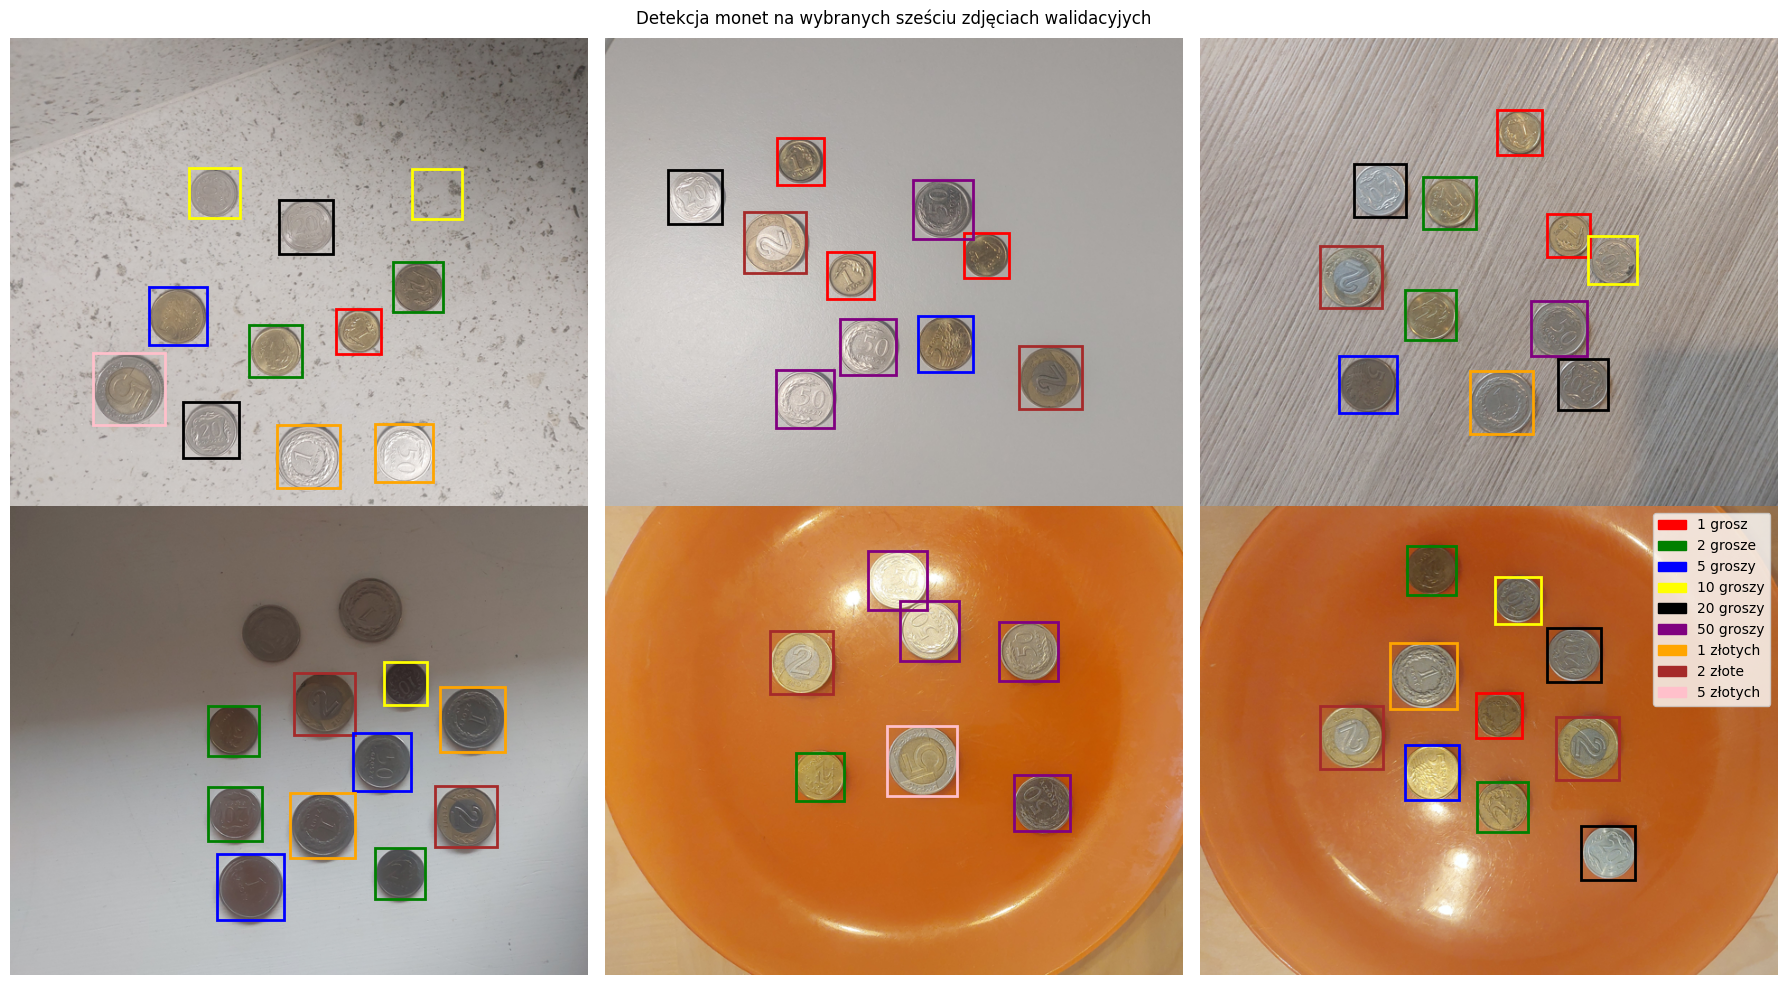

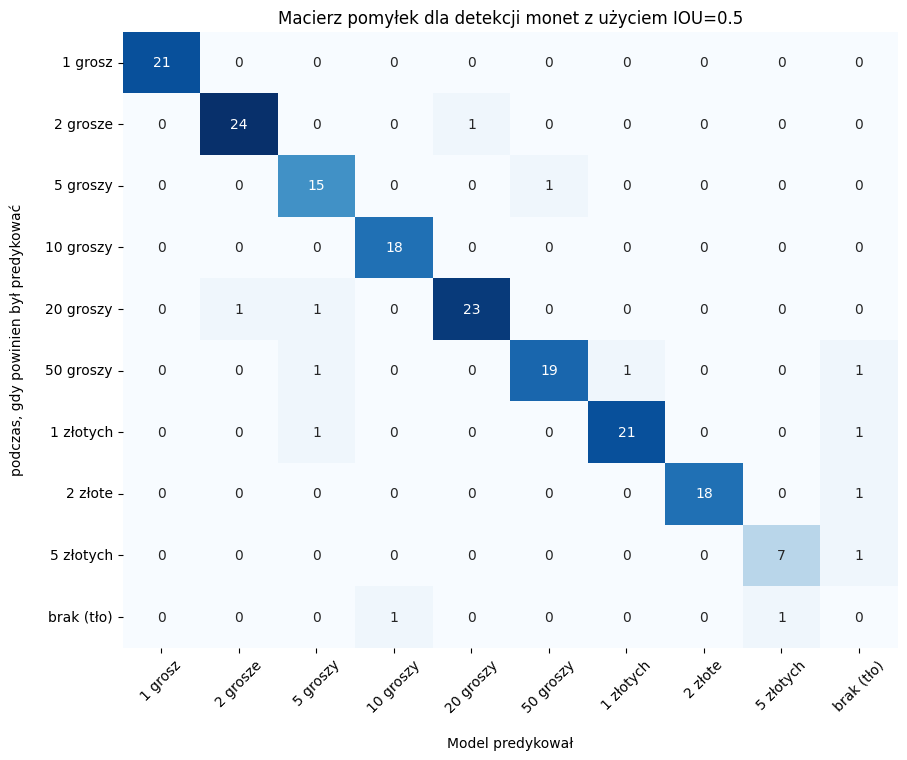

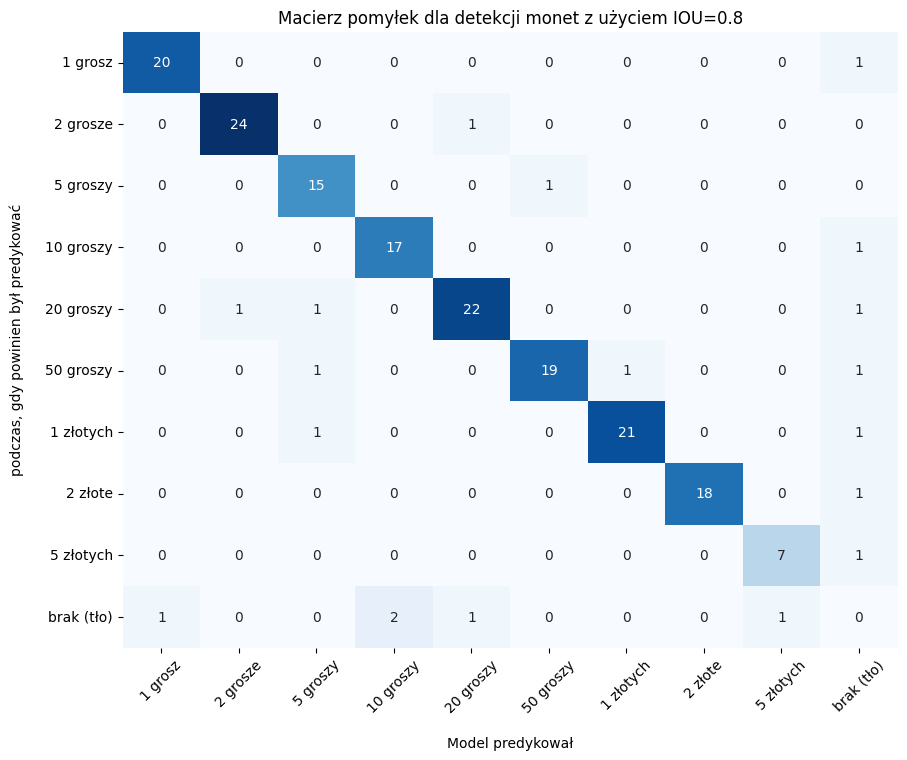

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

if not FINAL_EVALUATION_MODE:
    your_out = predict_all_bounding_boxes(your_model, val_ds)

    your_map_val = calculate_map(your_out, val_ds, return_all=False) # zwracamy tylko uśrednione mAP (główne kryterium oceny)

    score = (np.clip(your_map_val, 0.2, 0.85) - 0.2) / 0.65 * 100
    score = int(round(score))

    print(f"mAP na zbiorze walidacyjnym: {your_map_val:.2f}")
    print(f"Estymowana liczba punktów za zadanie: {score}")

    plot_detection_results_grid(your_out, val_ds)

    plot_confusion_matrix(your_out, val_ds, iou_threshold=0.5)
    plot_confusion_matrix(your_out, val_ds, iou_threshold=0.8)

Podczas sprawdzania model zostanie zapisany jako `your_model.pkl` i oceniony na zbiorze testowym.

In [17]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

if FINAL_EVALUATION_MODE:
    import cloudpickle

    # Gdy model posiada parametry, ustaw go w trybie ewaluacji i przenieś na CPU
    if list(your_model.parameters()):
        your_model.eval()
        your_model.cpu()

    OUTPUT_PATH = "file_output"
    FUNCTION_FILENAME = "your_model.pkl"
    FUNCTION_OUTPUT_PATH = os.path.join(OUTPUT_PATH, FUNCTION_FILENAME)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    with open(FUNCTION_OUTPUT_PATH, "wb") as f:
        cloudpickle.dump(your_model, f)